# Steps to use cartopy for plotting POP data

In [1]:
from intake import open_catalog
import cf_xarray
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds = cat['CESM_POP_hires_RCP8_5'].to_dask() # note that this is a climate change run!

If I were to naively try to plot SSH with cartopy, I would try something like the following:

CPU times: user 42 s, sys: 1.71 s, total: 43.7 s
Wall time: 44.5 s


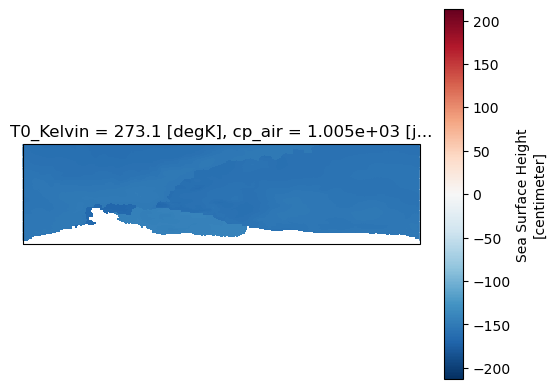

In [2]:
%%time
ax = plt.axes(projection=ccrs.PlateCarree())
ds.SSH_2.isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree())

This doesn't look right at all! I haven't selected any spatial region at all, so this should be a global plot, and shouldn't all be negative! Not to mention, this took a VERY long time to plot!

I'm going to explicitly tell cartopy what I want my x- and y-axes to be in case that wasn't clear.

CPU times: user 11.1 s, sys: 2.02 s, total: 13.1 s
Wall time: 13.5 s


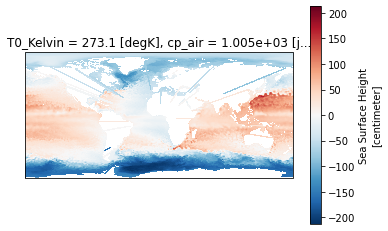

In [6]:
%%time
ax = plt.axes(projection=ccrs.PlateCarree())
ds.SSH_2.isel(time=0).plot(x='TLONG',y='TLAT',ax=ax,transform=ccrs.PlateCarree())

This looks much better! We have a global plot, and it took far less time to run. But, we have these weird artifacts streaking across the plot...

Let's try zooming in on our region to see if that makes the difference.

CPU times: user 3.27 s, sys: 1.06 s, total: 4.34 s
Wall time: 4.65 s


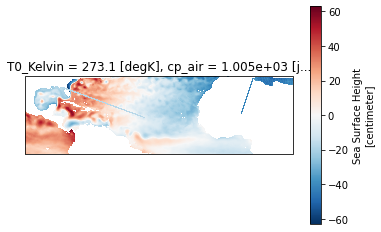

In [11]:
%%time
ax = plt.axes(projection=ccrs.PlateCarree())
ds.SSH_2.isel(time=0,nlat=slice(1150,1550),nlon=slice(80,1400)).plot(x='TLONG',y='TLAT',ax=ax,transform=ccrs.PlateCarree())

Nope, we still get these artifacts!They seem to be coming from the land boundaries, so it likely has something to do with the native land mask.

Let's apply the wet mask we've made previously to see if that will correct these artifacts.

In [12]:
# Create wet mask
wet_mask = xr.where(ds['KMT']>0, 1, 0)

CPU times: user 3.47 s, sys: 1.09 s, total: 4.56 s
Wall time: 6.77 s


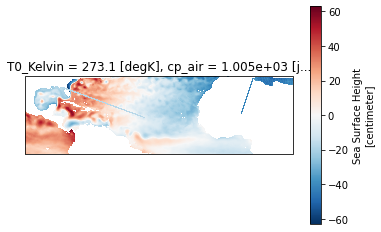

In [14]:
%%time
ax = plt.axes(projection=ccrs.PlateCarree())
ds.SSH_2.where(wet_mask).isel(time=0,nlat=slice(1150,1550),nlon=slice(80,1400)).plot(x='TLONG',y='TLAT',ax=ax,transform=ccrs.PlateCarree())

Still the same!

Here's where we use a bit of a hacky work-around (that I learned from someone else!). We will use a machine learning method of "erosion" to artificially expand the land mask just a touch, which will mask these few problem points causing the artifacts.

In [18]:
pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 18.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
%%time
# Try again by using erosion to expand the wet mask ever so slightly
from skimage.morphology import dilation, erosion, disk

mask_pop = xr.where(ds['KMT']>0, 1, 0) #ds_ren.TAREA > 0
mask_pop.data = erosion(mask_pop, selem=disk(1)) # & (ds_ren.KMT>1)

<timed exec>:5: FutureWarning: `selem` is a deprecated argument name for `erosion`. It will be removed in version 1.0. Please use `footprint` instead.


CPU times: user 407 ms, sys: 89.3 ms, total: 496 ms
Wall time: 610 ms


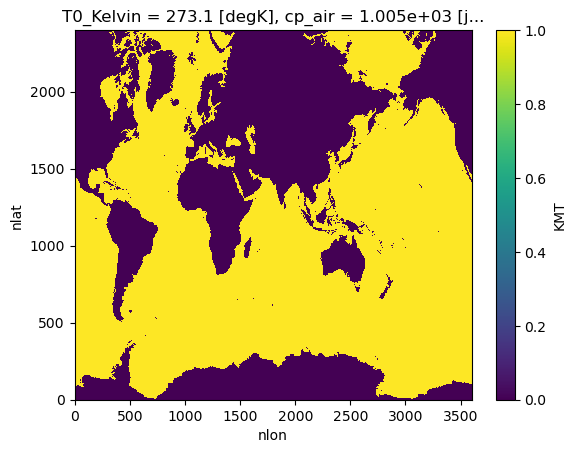

In [6]:
mask_pop.plot()

CPU times: user 4.2 s, sys: 1.07 s, total: 5.27 s
Wall time: 11.5 s


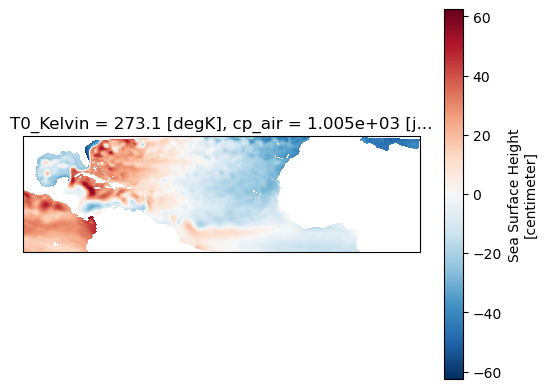

In [7]:
%%time
ax = plt.axes(projection=ccrs.PlateCarree())
ds.SSH_2.where(mask_pop).isel(time=0,nlat=slice(1150,1550),nlon=slice(80,1400)).plot(x='TLONG',y='TLAT',ax=ax,transform=ccrs.PlateCarree())